# Roll decay test parameter identification
Various ways to derive roll damping by parameter identification from roll decay tests are investigated.

Three different ways to conduct parameter identification are investigated:
* **report** : Values are taken from a SSPA report where damping is first extracted from time signal by measuring the peaks of the oscillation, using "Norwegian method".
* **sim** : Roll decay simulation is run in the optimization loop
* **direct** : Velocity and acceleration from the model test is derived numerically so that the roll diff equation can be solved directly without simulation.

## Conclusions



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

import os
from scipy.optimize import curve_fit, minimize, basinhopping

from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from rolldecay.simulation import roll_decay_time_step,simulate
import rolldecay
import rolldecay.read_funky_ascii
import inspect

## Roll decay model test

In [3]:
ascii_path = os.path.join(rolldecay.data_path,'project1','Ascii files','20084871056k.15.asc')
df = rolldecay.read_funky_ascii.read(ascii_path=ascii_path)
scale = 29.565
df.index*=np.sqrt(scale)  # To full scale

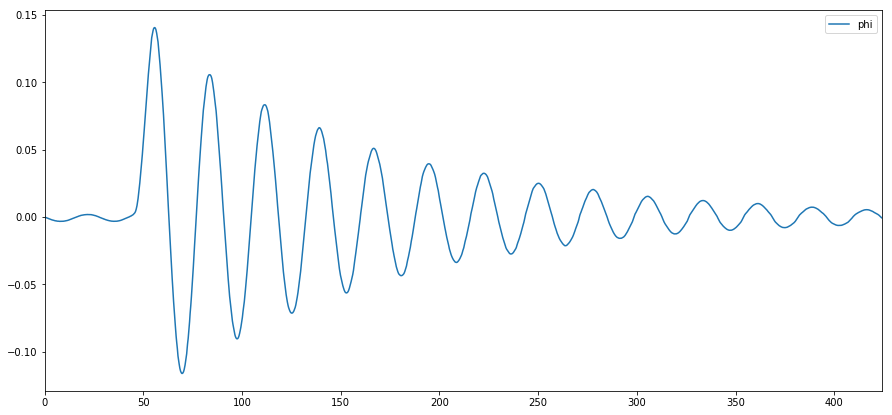

In [4]:
df.plot(y='phi')

### Cutting the file at max value 

In [5]:
index = df['phi'].abs().idxmax()
df_cut = df.loc[index:].copy()

In [6]:
from scipy import signal

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):

    if cutoff is None or order is None:
        # Disabled filter:
        return data

    b, a = butter_lowpass(cutoff, fs, order=order)
    #y = signal.lfilter(b, a, data)
    y = signal.filtfilt(b, a, data)

    return y

In [7]:
df_cut['phi_raw'] = df_cut['phi']

### Low pass filtration of signal to remove measurement noice

In [8]:
ts = np.mean(np.diff(df_cut.index))
fs = 1/ts
df_cut['phi'] = lowpass_filter(data=df_cut['phi_raw'], cutoff=0.1, fs=fs, order=5)

### Also cut the end of the signal

In [32]:
df_cut = df_cut.iloc[300:-300]

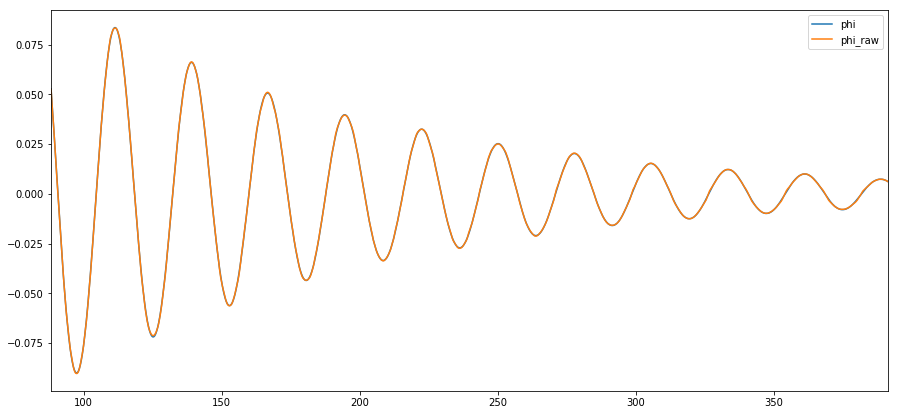

In [33]:
df_cut.plot(y=['phi','phi_raw'])

In [34]:
df_cut['phi1d'] = np.gradient(df_cut['phi'].values,df_cut.index.values)
df_cut['phi2d'] = np.gradient(df_cut['phi1d'].values,df_cut.index.values)

c:\dev\rolldecay\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\dev\rolldecay\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


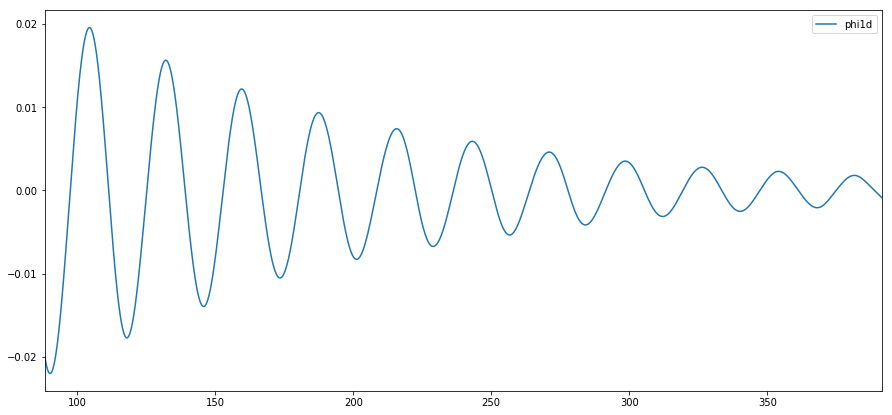

In [35]:
df_cut.plot(y='phi1d')

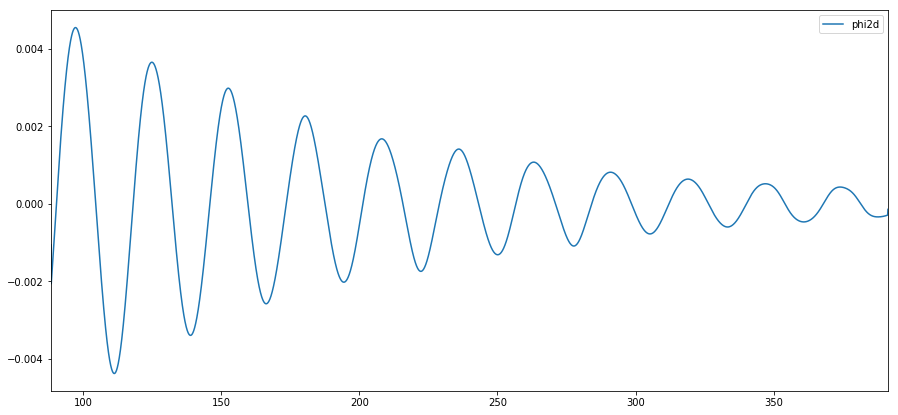

In [36]:
df_cut.plot(y='phi2d')

In [37]:
def f_direct(df, d, omega0, zeta):
    
    phi_old = df['phi']
    p_old = df['phi1d']
    
    phi2d = calculate_acceleration(d=d, omega0=omega0, p_old=p_old, phi_old=phi_old, zeta=zeta)
    return phi2d
    
def fit_direct(df, p0=None):
    
    popt,pcov = curve_fit(f=f_direct,xdata=df,ydata=df['phi2d'],p0=p0)
    signature = inspect.signature(f_direct)
    parameter_names = list(signature.parameters.keys())[1:]
    
    parameter_values = list(popt)
    parameters = dict(zip(parameter_names, parameter_values))
    
    return parameters,pcov


In [38]:
parameters_direct,pcov = fit_direct(df=df_cut)
parameters_direct

{'d': 0.14711153445053757,
 'omega0': 0.22645734524052605,
 'zeta': 0.03498991135729095}

In [39]:
phi0 = df_cut['phi'].iloc[0]
phi1d0 = df_cut['phi1d'].iloc[0]
df_sim_direct = simulate(t=df_cut.index, **parameters_direct, phi0=phi0, phi1d0=phi1d0)

In [40]:
def f(df, omega0, d, zeta):
    
    phi0 = df['phi'].iloc[0]
    phi1d0 = df['phi1d'].iloc[0]
    
    t = df.index
    df_sim = simulate(t=t, phi0=phi0, phi1d0=phi1d0, omega0=omega0, d=d, zeta=zeta)
    return np.array(df_sim['phi'])

In [41]:
def fit(f,df,p0=None):
    
    ydata = df['phi']
    
    if p0 is None:
        p0 = [1,1,1]
    
    popt,pcov = curve_fit(f=f,xdata=df,ydata=ydata,p0=p0)
    
    signature = inspect.signature(f)
    parameter_names = list(signature.parameters.keys())[1:]
    
    parameter_values = list(popt)
    parameters = dict(zip(parameter_names, parameter_values))
    
    return parameters


In [62]:
T0_guess = 27
omega0_guess = 2*np.pi/T0_guess
d_guess = 0.16  # Qudratic damping
zeta_guess = 0.03  # Linear damping
p0=[omega0_guess,d_guess,zeta_guess]
#p0=None

parameters = fit(f=f, df=df_cut, p0=p0)

In [63]:
parameters

{'d': 0.15977918207499997,
 'omega0': 0.23051644725585446,
 'zeta': 0.03026321396199997}

In [64]:
2*np.pi/parameters['omega0']

27.256993511641983

In [65]:
df_sim = simulate(t=df_cut.index, **parameters, phi0=phi0, phi1d0=phi1d0)

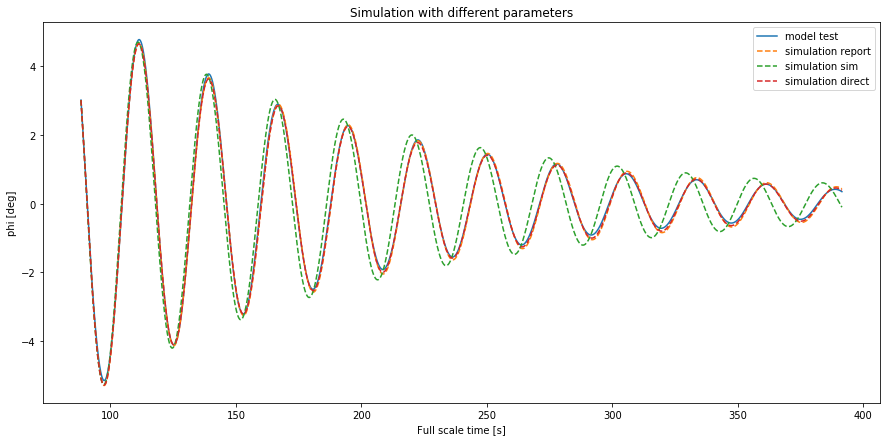

In [66]:
parameters_report = {
    'd': 0.165,
    'omega0': 2*np.pi/27.77,
    'zeta': 0.0336,
}


df_sim_report = simulate(t=df_cut.index, **parameters_report, phi0=phi0, phi1d0=phi1d0)

fig,ax = plt.subplots()

from collections import OrderedDict
dfs = OrderedDict()
dfs['model test']={'df':df_cut,'style':'-', 'alpha':1}
dfs['simulation report']={'df':df_sim_report}
dfs['simulation sim']={'df':df_sim}
dfs['simulation direct']={'df':df_sim_direct}

for label,data in dfs.items():
    df_ = data['df']
    style = data.get('style','--')
    alpha = data.get('alpha',1)
    ax.plot(df_.index,np.rad2deg(df_['phi']),style, label=label, alpha=alpha)

ax.legend()
ax.set_xlabel('Full scale time [s]')
ax.set_ylabel('phi [deg]')
ax.set_title('Simulation with different parameters');

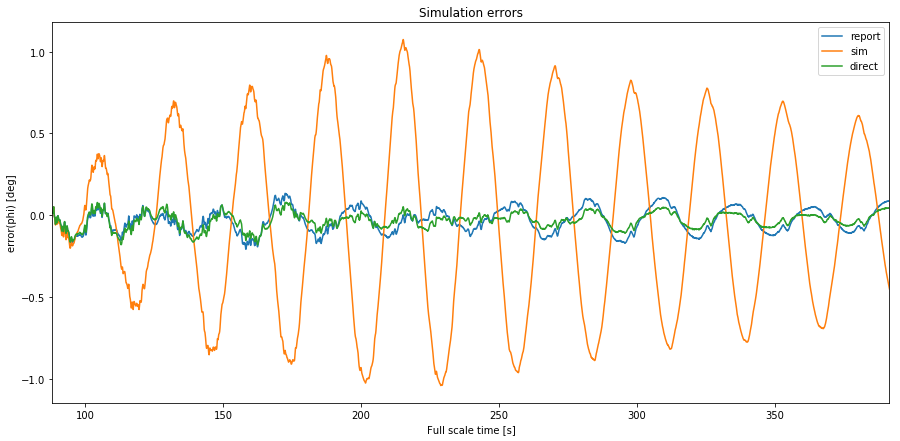

In [67]:
fig,ax = plt.subplots()
df_errors = pd.DataFrame(index=df_cut.index)
df_errors['report'] = df_sim_report['phi'] - df_cut['phi_raw']
df_errors['sim'] = df_sim['phi'] - df_cut['phi_raw']
df_errors['direct'] = df_sim_direct['phi'] - df_cut['phi_raw']

df_errors_deg = np.rad2deg(df_errors)

df_errors_deg.plot(ax=ax)
ax.set_title('Simulation errors')
ax.set_xlabel('Full scale time [s]')
ax.set_ylabel('error(phi) [deg]');


In [68]:
def RMS_error(error_phi,phi_max):
    return (np.sqrt((error_phi/phi_max)**2)).mean()

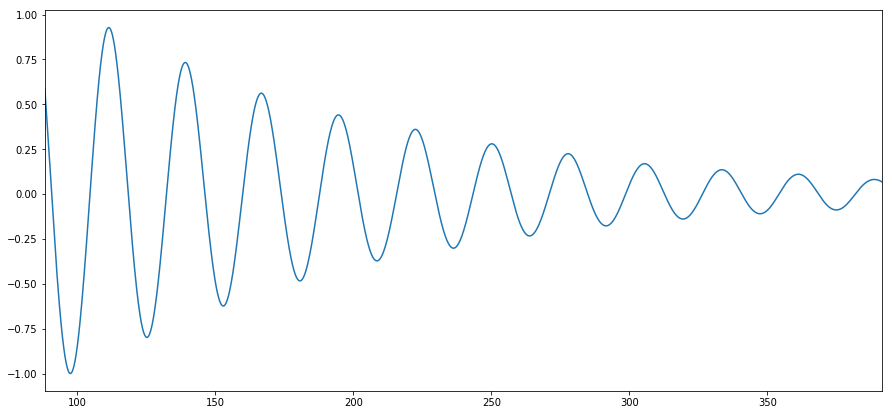

In [69]:
phi_max = df_cut['phi'].abs().max()
(df_cut['phi']/phi_max).plot()

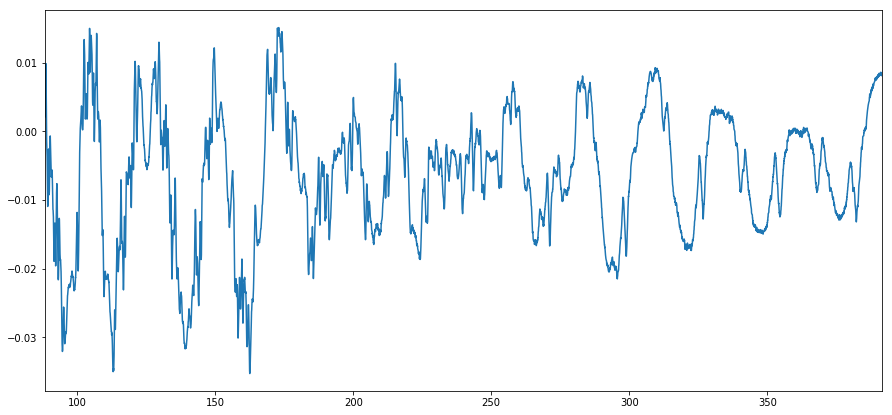

In [70]:
(df_errors['direct']/phi_max).plot()

Text(0.5, 1.0, "RMS error(phi'/max(phi))")

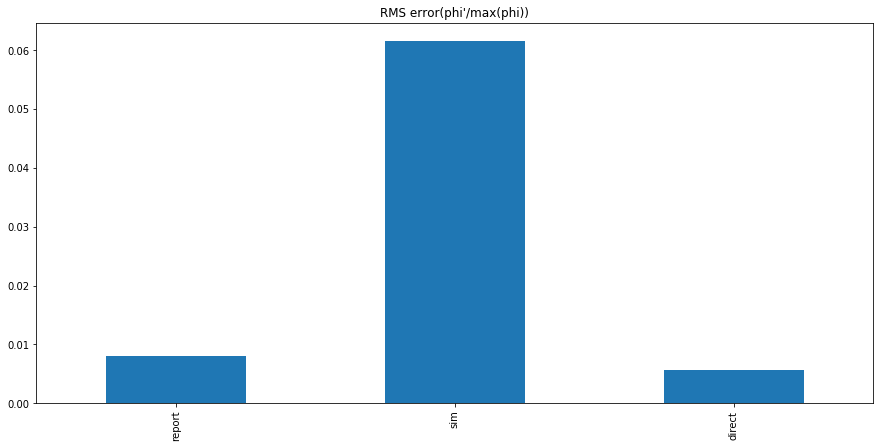

In [71]:
fig,ax = plt.subplots()
phi_max = df['phi'].abs().max()
s_RMS = df_errors.apply(func=RMS_error,phi_max=phi_max,axis=0)
s_RMS.plot(kind='bar');
ax.set_title("RMS error(phi'/max(phi))")

In [72]:

#def fit_optimize(df, p0=None):
#    
#    def error(x):
#    
#        omega0, d, zeta = x[0], x[1], x[2]
#    
#        phi_sim = f(df=df, omega0=omega0, d=d, zeta=zeta)
#        
#        phi = df['phi']
#        phi_max = phi.abs().max()
#        return (((phi_sim-phi)/phi_max)**2).mean()
#    
#    
#    if p0 is None:
#        p0 = [1,1,1]
#        
#    #return minimize(fun=error, x0=p0)
#    return basinhopping(func=error, x0=p0)
#    

In [73]:
#T0_guess = 27
#omega0_guess = 2*np.pi/T0_guess
#d_guess = 0.16  # Qudratic damping
#zeta_guess = 0.03  # Linear damping
#
#
#parameters = fit_optimize(df=df_cut, p0=[omega0_guess,d_guess,zeta_guess])

#parameters_optimize = {
#    'omega0':parameters.x[0],
#    'd':parameters.x[1],
#    'zeta':parameters.x[2],
#    
#}
#parameters_optimize

In [74]:
#df_sim2 = simulate(t=df_cut.index, **parameters_optimize, phi0=phi0, phi1d0=phi1d0)
#
#fig,ax = plt.subplots()
#df_cut.plot(y='phi', ax=ax, label='model test')
#df_sim2.plot(y='phi', ax=ax, label='simulation2')
#ax.set_title('Simulation with parameters from report')